<a href="https://colab.research.google.com/github/Aman56/grok/blob/main/parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Parity learning simulations

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n = 40 # string dimension
k = 3 # parity dimension
N = 1000 # #samples
B = 32 # batch size
lr = 0.1 # learning rate
T = int(20) # epochs

# Data generation
def parity(n, k, samples):

  input = torch.Tensor([[random.choice([-1, 1]) for j in range(n)] for i in range(samples)])
  target = torch.prod(input[:, n//2:n//2+k], dim=1) # parity hidden in the middle

  return input, target


class FF1(torch.nn.Module):
    def __init__(self, width=1000):
        super(FF1, self).__init__()
        self.linear1 = torch.nn.Linear(n, width)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(width, 1, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class MyHingeLoss(torch.nn.Module):
  def __init__(self):
    super(MyHingeLoss, self).__init__()

  def forward(self, output, target):
    hinge_loss = 1 - torch.mul(output, target)
    hinge_loss[hinge_loss < 0] = 0
    return hinge_loss

loss_fn = MyHingeLoss()

In [30]:
from torch.utils.data import TensorDataset, DataLoader
data = parity(n, k, N)
train_dataset = TensorDataset(data[0], data[1])
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

data = parity(n, k, 100)
test_dataset = TensorDataset(data[0], data[1])
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

data[0].shape, data[1].shape

(torch.Size([100, 40]), torch.Size([100]))

In [32]:
import matplotlib.pyplot as plt
    
def loss_calc(dataloader, model):
  loss = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    pred = model(x_batch)
    loss += loss_fn(pred, y_batch.to(device)).item()
  
  # if (id > 0):
  #   print('problem', id)
  #   assert 1 == 0
  if (id > 0):
    return loss / N
  else:
    return loss

num_seeds = 1
for seed_id in range(num_seeds):
  print(seed_id)
  model = FF1()
  model = model.to(device)
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  # for params in model.parameters():
  #     params.data = torch.randn(params.data.shape) * alpha
  #     init_net_params.append(copy.deepcopy(params.detach()))

  train_loss, test_loss = [], []
  for epoch in range(T):
    if (epoch // 250 == 1):
      print(f"Epoch {epoch + 1}\n-------------------------------")

    train_loss.append(loss_calc(train_dataloader, model))
    test_loss.append(loss_calc(test_dataloader, model))
    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      pred = model(x_batch)

      optimizer.zero_grad()
      loss = loss_fn(pred, y_batch.to(device)).mean()
      loss.backward()
      optimizer.step()

  
  plt.plot(train_loss)
  plt.show()

    # for i in range(T):
      
    #     outputs_tst = torch.squeeze(model(Xtst.T))
    #     loss = loss_fn(outputs_tst, Ytst)
    #     loss_curve[i] = loss.detach()

    #     X = torch.normal(0, 1, size=(d, N)).to(device)
    #     Y = torch.matmul(b, F.relu(torch.matmul(V, X))).to(device)

    #     optimizer.zero_grad()
    #     outputs = torch.squeeze(model(X.T))
    #     loss = loss_fn(outputs, Y)
    #     loss.backward()
    #     optimizer.step()

    #     #if(i % 1000 == 0):
    #     #    print(i, loss.detach())

    # net_params = []
    # net_grads = []

    # for params in model.parameters():
    #     net_grads.append(params.grad)
    #     net_params.append(params.detach())

    # state = {'loss': loss_curve,
    #         'init_net_params': init_net_params,
    #         'net_params': net_params,
    #         'net_grads': net_grads}

    # plt.plot(state['loss'])
    # plt.show()

    # plt.imshow(state['net_params'][0] @ V.T)
    # plt.colorbar()
    # plt.show()

0


ValueError: ignored

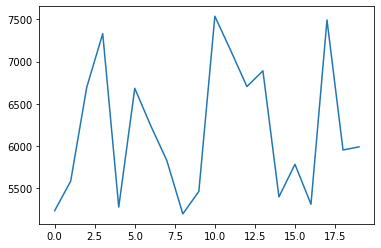

In [27]:
plt.plot(test_loss)
plt.show()